# Import of libraries and data, and preprocessing

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from files.preprocessing import *

In [2]:
data_raw=pd.read_csv("./data/Train.csv")
meta=pd.read_csv("./data/airqo_metadata.csv")

data_less_raw = data_raw.copy()

def replace_nan(x):
        if x==" ":
            return np.nan
        else :
            return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    data_less_raw[feature]=data_less_raw[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])

In [3]:
# TODO request "keep_location" argument
data = preprocessing(data_raw, use_location=False, only_means=False, keep_location=True)

/Users/mkinzler/neuefische/ML-Project-1/files/preprocessing.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(features,1,inplace=True)


# Plots

In [4]:
station_order = ['A', 'B', 'C', 'D', 'E'] 

## Target (PM2.5)

In [5]:
data.groupby('location')[['target']].describe()

target                                                         \
           count       mean        std        min        25%        50%   
location                                                                  
A         5122.0  57.654407  40.153730   1.452619  33.945973  46.801340   
B          767.0  49.864973  31.257994   5.364419  27.946675  43.527442   
C         1753.0  97.772233  71.094473  14.514348  44.751304  72.774667   
D         4990.0  58.155597  30.230180   6.163191  38.458511  50.526938   
E         2907.0  37.800361  22.487640   2.150000  23.144689  32.986667   

                                  
                 75%         max  
location                          
A          68.479103  447.340000  
B          62.150756  171.252564  
C         130.600417  475.820000  
D          69.716117  287.689412  
E          45.665000  218.505385

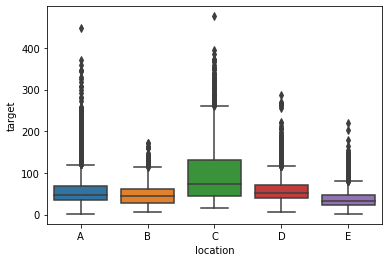

In [6]:
sns.boxplot(data=data, x='location', y='target', order=station_order);

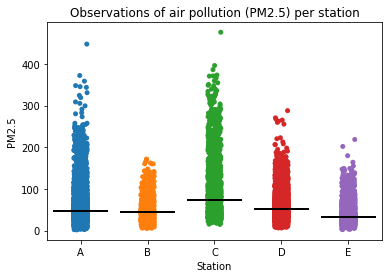

In [7]:
sns.stripplot(data=data, x='location', y='target', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='target', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Observations of air pollution (PM2.5) per station', xlabel='Station', ylabel = 'PM2.5')
plt.savefig('images/pm2_5_per_station.jpg');

## Metadata (influence of surrounding on pollution)

### Cooking with charcoal (and firewood), and burning of waste

In [8]:
meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential', 'popn', 'hh', 'hh_cook_charcoal', 'hh_cook_firewood', 'hh_burn_waste']]

,location,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste
0,A,NaN,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142
1,B,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809,22243,5735,116,1144,239
2,C,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835
3,D,NaN,265.896472,NaN,339.693908,76.024389,11.601442,3596,663,7,651,99
4,E,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589,6064,1297,985,26,43


In [9]:
# doesn't include hh_cook_firewood!

# cook_burn = meta[['location', 'hh_cook_charcoal', 'hh_cook_firewood', 'hh_burn_waste']].set_index('location')
cook_burn = meta[['location', 'hh_cook_charcoal', 'hh_burn_waste']].set_index('location')

# cook_burn.columns = 'cooking w/ charcoal', 'cooking w/ firewood', 'burning waste'
cook_burn.columns = 'cooking w/ charcoal', 'burning waste'
cook_burn

,cooking w/ charcoal,burning waste
location,,
A,508,142
B,116,239
C,21316,9835
D,7,99
E,985,43


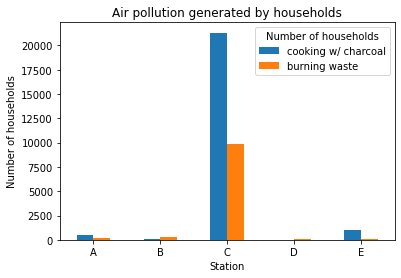

In [44]:
ax = cook_burn.plot(kind='bar')
ax.set(xlabel = 'Station', ylabel='Number of households', title='Air pollution generated by households')
ax.legend(title='Number of households')
plt.xticks(rotation=0)
ax.get_figure().savefig('images/n_hh_cooking_burning.jpg')

### Roads nearby

In [67]:
meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential']].set_index('location')

,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential
location,,,,,,
A,NaN,14.695789,343.595039,575.917422,330.609776,254.307415
B,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809
C,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350
D,NaN,265.896472,NaN,339.693908,76.024389,11.601442
E,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589


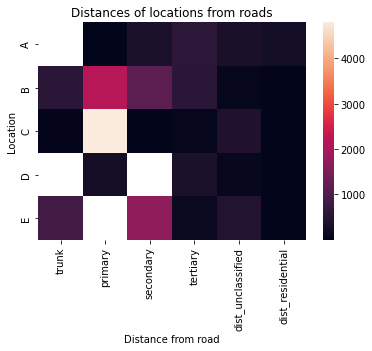

In [98]:
# without 'dist_tertiary 'dist_unclassified', 'dist_residential'
dist_roads = meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential']].set_index('location')
dist_roads.columns = ['trunk', 'primary', 'secondary', 'tertiary', 'dist_unclassified', 'dist_residential']
sns.heatmap(dist_roads).set(xlabel='Distance from road', ylabel='Location', title='Distances of locations from roads');

## Distribution of features

### Temperature

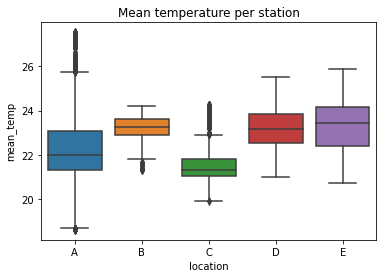

In [12]:
sns.boxplot(data=data, x='location', y='mean_temp', order=station_order).set(title='Mean temperature per station');

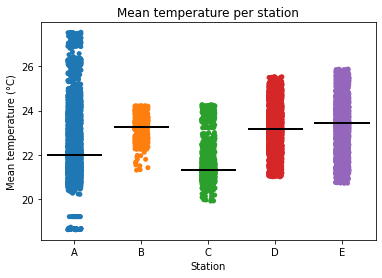

In [13]:
sns.stripplot(data=data, x='location', y='mean_temp', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_temp', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean temperature per station', xlabel='Station', ylabel = 'Mean temperature (°C)')
plt.savefig('images/mean_temp_per_station.jpg');

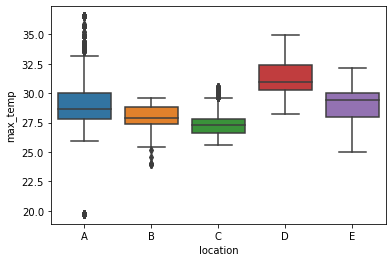

In [14]:
sns.boxplot(data=data, x='location', y='max_temp', order=station_order);

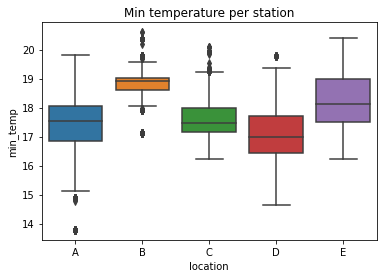

In [15]:
sns.boxplot(data=data, x='location', y='min_temp', order=station_order).set(title='Min temperature per station');

### Atmos. pressure

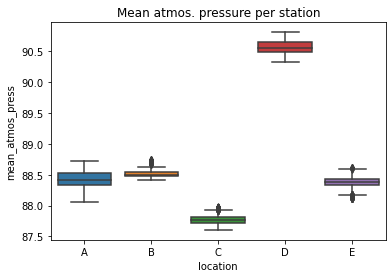

In [16]:
sns.boxplot(data=data, x='location', y='mean_atmos_press', order=station_order).set(title='Mean atmos. pressure per station');

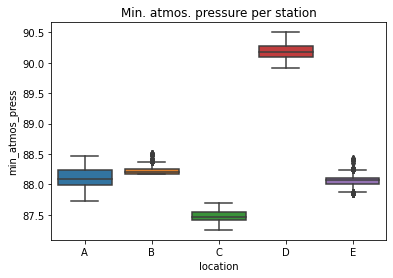

In [17]:
sns.boxplot(data=data, x='location', y='min_atmos_press', order=station_order).set(title='Min. atmos. pressure per station');

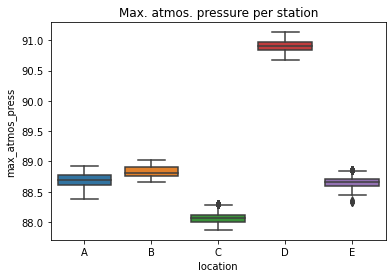

In [18]:
sns.boxplot(data=data, x='location', y='max_atmos_press', order=station_order).set(title='Max. atmos. pressure per station');

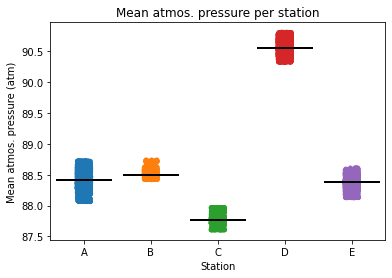

In [19]:
sns.stripplot(data=data, x='location', y='mean_atmos_press', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_atmos_press', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean atmos. pressure per station', xlabel='Station', ylabel = 'Mean atmos. pressure (atm)')
plt.savefig('images/mean_atmos_press_per_station.jpg');

### Wind speed

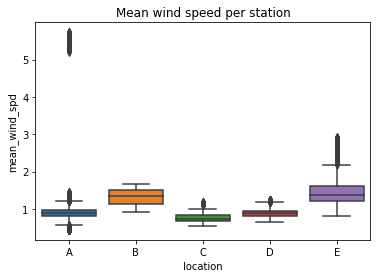

In [20]:
sns.boxplot(data=data, x='location', y='mean_wind_spd', order=station_order).set(title='Mean wind speed per station');

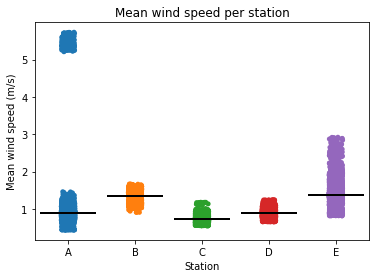

In [21]:
sns.stripplot(data=data, x='location', y='mean_wind_spd', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_wind_spd', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean wind speed per station', xlabel='Station', ylabel = 'Mean wind speed (m/s)')
plt.savefig('images/mean_wind_spd_per_station.jpg');

### Precipitation

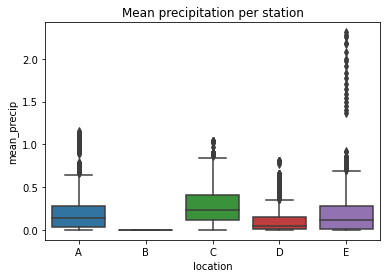

In [22]:
sns.boxplot(data=data, x='location', y='mean_precip', order=station_order).set(title='Mean precipitation per station');

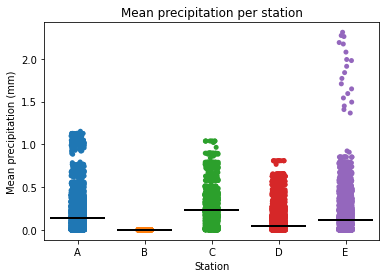

In [23]:
sns.stripplot(data=data, x='location', y='mean_precip', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_precip', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean precipitation per station', xlabel='Station', ylabel = 'Mean precipitation (mm)')
plt.savefig('images/mean_precip_per_station.jpg');

## Data quality

### NaNs per observation

In [24]:
nans_per_obs = data_less_raw.copy()

features = ['temp', 'wind_dir', 'wind_spd', 'rel_humidity', 'atmos_press', 'precip']

for feature in features : 
    nans_per_obs[feature]=nans_per_obs[feature].apply(lambda x: np.count_nonzero(np.isnan(x)))

In [25]:
nans_per_obs

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,105,105,105,105,105,105,45.126304
1,ID_train_1,D,0,0,0,0,0,0,79.131702
2,ID_train_10,A,1,1,1,46,46,1,32.661304
3,ID_train_100,A,0,0,0,51,51,0,53.850238
4,ID_train_1000,A,91,91,91,91,91,91,177.418750
...,...,...,...,...,...,...,...,...,...
15534,ID_train_9995,A,0,0,1,48,48,0,44.850286
15535,ID_train_9996,E,0,0,0,6,6,0,24.330455
15536,ID_train_9997,D,1,0,1,0,0,0,38.972128
15537,ID_train_9998,D,0,0,0,0,0,0,41.720952


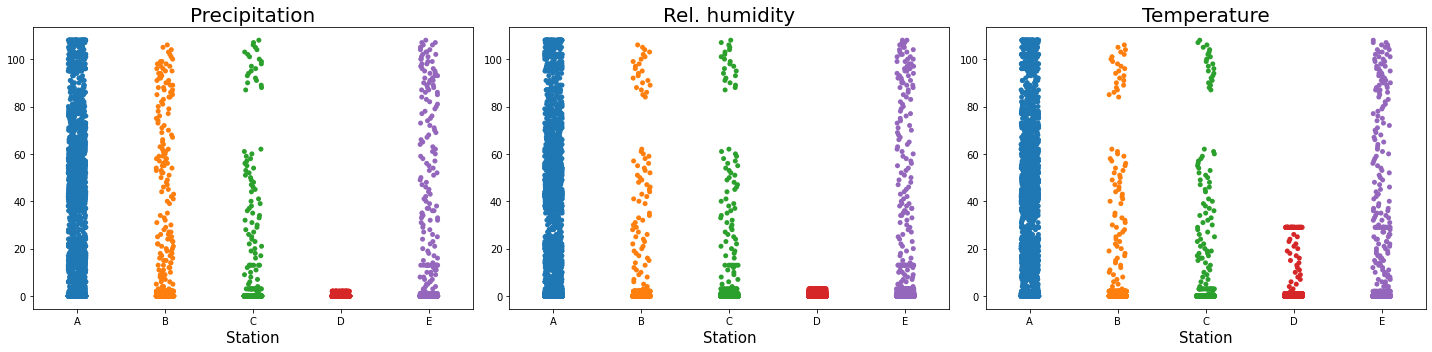

In [26]:
# Wind dir. and Wind speed like Temp.
# Atmos. pressure like Rel. humidity
features_order = ['precip', 'rel_humidity', 'temp']
features_pretty = {'temp': 'Temperature', 'wind_dir': 'Wind direction', 'wind_spd': 'Wind speed', 'rel_humidity': 'Rel. humidity', 'atmos_press': 'Atmos. pressure', 'precip': 'Precipitation'}
fig, ax = plt.subplots(1, len(features_order), figsize=(20,5))
for i, f in enumerate(features_order):
    sns.stripplot(data=nans_per_obs, x='location', y=f, order=station_order, ax=ax[i])
    ax[i].set_title(features_pretty[f], fontsize=20)
    ax[i].set_xlabel('Station', fontsize=15)
    ax[i].set_ylabel('')
# fig.suptitle('Missing Values in Observation', fontsize=30)
fig.tight_layout()
fig.savefig('images/missing_values_in_observation.jpg')

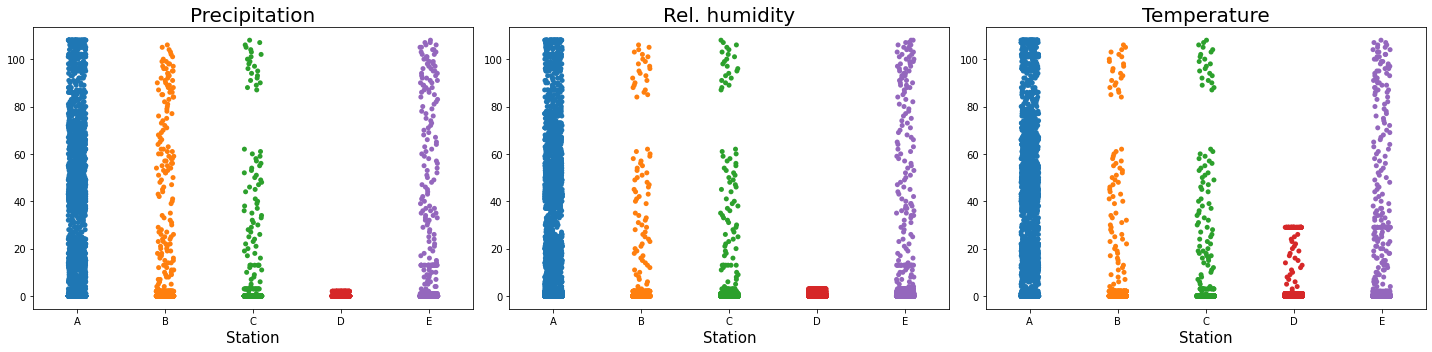

In [27]:
# Wind dir. and Wind speed similar to Temp.,
# Atmos. pressure similar to Rel. humidity,
# therefore left out

features_order = ['precip', 'rel_humidity', 'temp']
features_pretty = {'temp': 'Temperature', 'wind_dir': 'Wind direction', 'wind_spd': 'Wind speed', 'rel_humidity': 'Rel. humidity', 'atmos_press': 'Atmos. pressure', 'precip': 'Precipitation'}
fig, ax = plt.subplots(1, len(features_order), figsize=(20,5))
for i, f in enumerate(features_order):
    sns.stripplot(data=nans_per_obs, x='location', y=f, order=station_order, ax=ax[i])
    ax[i].set_title(features_pretty[f], fontsize=20)
    ax[i].set_xlabel('Station', fontsize=15)
    ax[i].set_ylabel('')
# fig.suptitle('Missing Values in Observation', fontsize=30)
fig.tight_layout()
fig.savefig('images/missing_values_in_observation.jpg')

### NaNs per location (count, mean, median, max)

In [28]:
# count
nans_per_loc = nans_per_obs.groupby(['location']).sum()
nans_per_loc

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,
A,99461,97630,99225,149105,149105,97630,295305.872256
B,4244,8246,4244,6290,6290,4244,38246.434159
C,4137,4116,4229,5376,5376,4116,171394.724878
D,1981,123,1427,14119,14119,123,290196.429703
E,9418,8663,8987,19997,19997,8663,109885.650665


In [29]:
# mean
mean_nans_per_loc = nans_per_obs.groupby(['location']).mean()
mean_nans_per_loc

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,
A,19.418391,19.060914,19.372316,29.110699,29.110699,19.060914,57.654407
B,5.533246,10.750978,5.533246,8.200782,8.200782,5.533246,49.864973
C,2.359954,2.347975,2.412436,3.066743,3.066743,2.347975,97.772233
D,0.396994,0.024649,0.285972,2.829459,2.829459,0.024649,58.155597
E,3.239766,2.980048,3.091503,6.878913,6.878913,2.980048,37.800361


In [30]:
# TODO check
# median
median_nans_per_loc = nans_per_obs.groupby(['location']).median()
median_nans_per_loc

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,
A,0.0,0.0,1.0,18.0,18.0,0.0,46.801340
B,0.0,0.0,0.0,0.0,0.0,0.0,43.527442
C,0.0,0.0,0.0,0.0,0.0,0.0,72.774667
D,0.0,0.0,0.0,0.0,0.0,0.0,50.526938
E,0.0,0.0,0.0,0.0,0.0,0.0,32.986667


In [31]:
# max
max_nans_per_loc = nans_per_obs.groupby(['location']).max()
max_nans_per_loc

,ID,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,,
A,ID_train_9995,108,108,108,108,108,108,447.340000
B,ID_train_9959,106,106,106,108,108,106,171.252564
C,ID_train_9999,108,108,108,108,108,108,475.820000
D,ID_train_9998,29,2,3,31,31,2,287.689412
E,ID_train_9996,108,108,108,108,108,108,218.505385
